In [1]:
%reload_ext autoreload
%autoreload 2 

In [ ]:
import torch, numpy as np, torch.nn as nn, warnings, matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

from data import ImagenetVidDatatset, collate_fn, ValidSamplerSubset, ValidSampler
from model import Generic_Matching_Net, config
from torch.utils.data import DataLoader, RandomSampler, BatchSampler
from pathlib import Path
from catalyst.dl import SupervisedRunner, Callback, State, CallbackNode, CallbackOrder, SchedulerCallback
from collections import OrderedDict, defaultdict

### misc

In [ ]:
bs=4
trn_ds = ImagenetVidDatatset()
sampler = RandomSampler(trn_ds, num_samples=int(trn_ds.len_total()), replacement=True)
trn_sampler = BatchSampler(sampler, batch_size=bs, drop_last=False)
trn_dl = DataLoader(trn_ds, batch_sampler=trn_sampler, collate_fn=collate_fn)
trn_steps_per_epoch = len(trn_sampler)

In [ ]:
data = next(iter(trn_dl))
data.keys()

In [ ]:
val_steps_per_epoch = 100
val_ds = ImagenetVidDatatset(mode='valid', patch_augment=False,)
val_sampler = ValidSampler(val_ds)
val_sampler = BatchSampler(val_sampler, batch_size=bs, drop_last=False)
val_dl = DataLoader(val_ds, batch_sampler=val_sampler, collate_fn=collate_fn, )

In [ ]:
data = next(iter(val_dl))
data.keys()

In [ ]:
data['targets'].shape

In [ ]:
model = model.Generic_Matching_Net(config=model.config)
#model

In [ ]:
img, exp = torch.rand(3, 3, 255,255), torch.rand(3, 3, 63,63)
out = model((img, exp))
out['logits'].shape

### Training


In [ ]:
class CenterWeightedMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, preds, targets):
        if isinstance(preds, dict):
            preds = preds['logits']
        
        preds = preds.cpu()
        targets = targets.cpu()
        
        mask = torch.as_tensor(torch.randn_like(targets) > 0.8, dtype=torch.float)
        radius = 8
        size_map = [*preds.shape[-2:]]
        center = torch.zeros_like(preds)
        
        center[:, :, 
               size_map[0] // 2 - radius: size_map[0] // 2 + radius, 
               size_map[1] // 2 - radius: size_map[1] // 2 + radius] = 1
        
        center = mask + 10. * center

        loss = torch.mul(center, (preds - targets) ** 2).squeeze()
        return loss.mean()           
                    
        

criterion = CenterWeightedMSELoss()
o = criterion(out['logits'], data['targets'])
o

In [ ]:
BS = 64
EPOCHS = 25
nw = 8 
trn_ds = ImagenetVidDatatset()
trn_sampler = RandomSampler(trn_ds, num_samples=trn_ds.len_total(), replacement=True)
trn_batch_sampler = BatchSampler(trn_sampler, batch_size=BS, drop_last=False)
trn_dl = DataLoader(trn_ds, batch_sampler=trn_batch_sampler, collate_fn=collate_fn, num_workers=nw)
                    
val_ds = ImagenetVidDatatset(mode='valid', patch_augment=False,)
#val_sampler = ValidSamplerSubset(val_ds, num_samples=100)
val_sampler = ValidSampler(val_ds)
val_batch_sampler = BatchSampler(val_sampler, batch_size=BS, drop_last=False)
val_dl = DataLoader(val_ds, batch_sampler=val_batch_sampler, collate_fn=collate_fn, num_workers=nw)

dataloaders = OrderedDict(
                train=trn_dl,
                valid=val_dl)


In [ ]:
optimizer_config = OrderedDict(
                        name='adam', 
                        adapt_lr=0.0, 
                        main_lr=2.5e-4,
                        weight_decay=1e-4, 
                        momentum=0.9)

In [ ]:
def get_optimizer(config, model,):
    from functools import partial
    from torch.optim import Adam, AdamW, SGD

    OPTIMS = {'adam': partial(Adam, weight_decay=config['weight_decay']),
              'sgd': partial(SGD, momentum=config['momentum']),
              'adamw': partial(AdamW, weight_decay=config['weight_decay'])}


    adapt_params = defaultdict(list)
    adapt_params['lr'] = config['adapt_lr']
    main_params = defaultdict(list)
    main_params['lr'] = config['main_lr']

    for name, param in model.named_parameters():
        if 'adapt' in name:
            param.requires_grad = bool(adapt_params['lr'])
            adapt_params['params'].append(param)
            #adapt_params['names'].append(name)
        else: 
            main_params['params'].append(param)
            #main_params['names'].append(name)

    optimizer = OPTIMS[config['name']](params=[adapt_params, main_params])

    return optimizer

In [ ]:
#this will depend on the lr scheduler
base_lr_scheduler_config = lambda x: defaultdict(schedule=x)

#onecycle
onecycle_lr_config = base_lr_scheduler_config('onecycle')
onecycle_lr_config['pct_start'] = 0.2
onecycle_lr_config['epochs'] = EPOCHS
onecycle_lr_config['steps_per_epoch'] = len(trn_batch_sampler)

##linear warmup
#linear_warmup_config = base_lr_scheduler_config('linear_warmup')
#linear_warmup_config['warmup_period'] = 1000
#linear_warmup_config['bs'] = BS


In [ ]:
def get_lr_schedule(config, optimizer):
    from torch.optim.lr_scheduler import LambdaLR, OneCycleLR, ReduceLROnPlateau
    
    schedule = config['schedule'].lower()
    print(f'{schedule} LR schedule')

    if schedule == 'linear_warmup':
        assert 'bs' in config.keys(), 'Batch size "bs" is missing from config dict'
        scheduler = LambdaLR(optimizer, lambda epoch: min(epoch / (config['warmup_period'] / config['bs']), 1.0))
        
    elif schedule == 'onecycle':
        assert 'epochs' in config.keys(), 'Number of epochs missing from config dict'
        assert 'steps_per_epoch' in config.keys(), '"steps_per_epoch" missing from config dict'
        lrs = [item['lr'] for item in optimizer.state_dict()['param_groups']]
        scheduler = OneCycleLR(optimizer, max_lr=lrs, epochs=config['epochs'],
                               steps_per_epoch=config['steps_per_epoch'], pct_start=config['pct_start'])
    elif schedule == 'reduce':
        scheduler = ReduceLROnPlateau(optimizer)
    else:
        scheduler = LambdaLR(optimizer, lambda epoch: 1.)
        print('Constant LR. No schedule')
        
    return scheduler

    

Initially modified the scheduler.py file in catalyst/core/Callbacks folder to account for Pytorch Onecyclelr. This is not necessary. Instead set `mode` argument in SchedulerCallback equal to batch. This will perform the lr update after each batch. 

Also couldn't figure out how to log the Learning rates with the logger/tensorboard. Had to write custom callback

In [ ]:
LRs = {0: 'adapter', 
       1: 'main'}
class LRLogger(Callback):
    def __init__(self,):
        super().__init__(order=CallbackOrder.Logging, node=CallbackNode.All)
    # override 
    def _throw_on_tensorboard(self, state: State, step, name):
        tensorboard = state.callbacks['_tensorboard'].loggers['train']
        if isinstance(state.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            for ll, slr in enumerate(state.scheduler.optimizer.param_groups):
                tensorboard.add_scalar(f"LR/{LRs[ll]}/{name}", slr['lr'], step)
        else:
            for ll, slr in enumerate(state.scheduler.get_last_lr()):
                tensorboard.add_scalar(f"LR/{LRs[ll]}/{name}", slr, step)
                
    def on_batch_end(self, state: State):
        # every train loader
        if not state.need_backward_pass:
            return
        self._throw_on_tensorboard(state, state.global_step, 'batch')
    
    def on_epoch_end(self, state: State):
        if not state.need_backward_pass:
            return
        
        self._throw_on_tensorboard(state,  state.global_epoch, 'epoch')
        

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Generic_Matching_Net(config=config)
optimizer = get_optimizer(optimizer_config, model)
lr_scheduler = get_lr_schedule(onecycle_lr_config, optimizer)

runner = SupervisedRunner( 
                          device=device,
                          input_key='images',
                          output_key='logits',
                          input_target_key = 'targets')

In [ ]:
runner.train(model,
             optimizer=optimizer,
             criterion=CenterWeightedMSELoss(), 
             loaders=dataloaders,
             logdir='./runs/',
             callbacks=[SchedulerCallback(mode='batch'), LRLogger()],
             scheduler=lr_scheduler,
             num_epochs=EPOCHS, 
             verbose=False,)

### Visualization

In [3]:
from data import IMAGENET_STATS
import torchvision.transforms as tfms
def reverse_normalize_image(imgs, permute=False):
    mean = ( -torch.as_tensor(IMAGENET_STATS['mean']) / torch.as_tensor(IMAGENET_STATS['std']))
    tfms_reverse = tfms.Normalize(mean.tolist(), (1.0 / torch.as_tensor(IMAGENET_STATS['std'])).tolist())
    imgs = torch.stack([tfms_reverse(ii) for ii in imgs.cpu()])
    if permute:
        imgs = imgs.permute(0, 2, 3, 1)
    return imgs


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Generic_Matching_Net(config=config)
model.load_state_dict(torch.load(Path('./runs/checkpoints/best.pth'), map_location=device)['model_state_dict'])
model.eval()
model = model.to(device)

Loading imagenet weights.


#### Imagenet Vid

In [ ]:
BS = 24
val_ds = ImagenetVidDatatset(mode='valid', patch_augment=False,)
val_sampler = RandomSampler(val_ds, num_samples=val_ds.len_total(), replacement=True)
val_batch_sampler = BatchSampler(val_sampler, batch_size=BS, drop_last=False)
val_dl = DataLoader(val_ds, batch_sampler=val_batch_sampler, collate_fn=collate_fn, num_workers=nw)
data = next(iter(val_dl))

In [ ]:
logits = model([x.to(device) for x in data['images']])['logits'].detach().cpu().numpy()

In [ ]:
images = reverse_normalize_image(data['images'][0]).permute(0, 2, 3, 1)
patches = reverse_normalize_image(data['images'][1]).permute(0, 2, 3, 1)

In [ ]:
fig, ax  = plt.subplots(1, 2)
i = np.random.choice(64)
ax[0].imshow(data['targets'][i].squeeze())
ax[1].imshow(logits[i].squeeze())

In [ ]:
(logits[i]).sum()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i = np.random.choice(BS)

ax[0].imshow(patches[i])
ax[1].imshow(images[i])
ax[2].imshow(logits[i].squeeze())

for a,t  in zip(ax, ['Patch', 'Image', 'heatmap']):
    a.set_title(t)


#### Apply to DOTA

In [5]:
from data import DOTADatasetO

In [7]:
ds = DOTADataset(transform=True)
dl = DataLoader(ds, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, "['Large_Vehicle']")

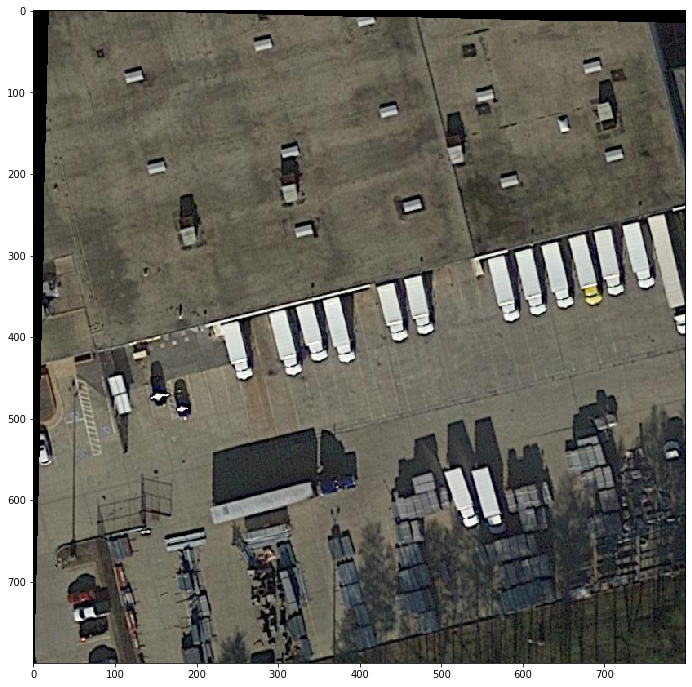

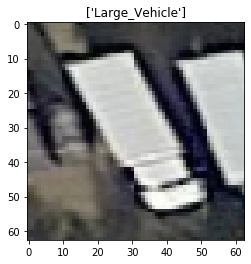

In [8]:
out = next(iter(dl))
plt.figure(figsize=(12, 12))
plt.imshow(reverse_normalize_image(out['image'], permute=True).squeeze())
plt.figure()
plt.imshow(reverse_normalize_image(out['patch'], permute=True).squeeze())
plt.title(out['patch_category'])

In [9]:
logits = model([out['image'].to(device), out['patch'].to(device)])['logits'].detach().cpu().numpy().squeeze()


Text(0.5, 1.0, 'Heatmap')

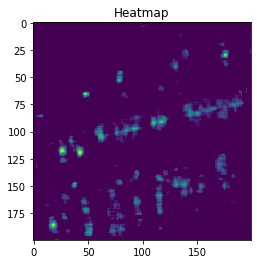

In [10]:
plt.imshow(logits.squeeze())
plt.title('Heatmap')

In [17]:
logits.sum()/100.

20.269345703125

Text(0.5, 1.0, 'groundtruth')

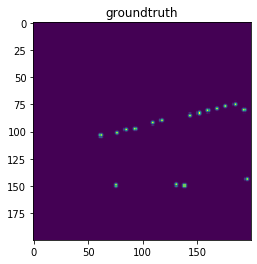

In [11]:
plt.imshow(tfms.ToPILImage()(out['gt']).resize((200, 200)))
plt.title('groundtruth')

In [14]:
out['gt'].sum()/100.

tensor(16.9999)

In [26]:
heatmap = logits.squeeze()
coords = peak_local_max(heatmap, min_distance=10)

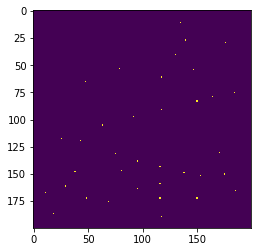

In [27]:
black = np.zeros_like(heatmap)
black[coords[:,0], coords[:, 1]] = 1
plt.imshow(black)

### Git

In [ ]:
!git status

In [ ]:
!git add training-playground-catalyst.ipynb

In [ ]:
!git commit -m 'visualization of results and applying model to DOTA'

In [ ]:
!git push

In [ ]:
%debug